In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Display the measurement db row's columns and data in dictionary format
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21b966f8e80>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [11]:
# Display the station db row's columns and data in dictionary format
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21b967145e0>,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'elevation': 3.0,
 'id': 1}

# Exploratory Precipitation Analysis

In [12]:
# Total dates
session.query(func.count(measurement.date)).all()

[(19550)]

In [13]:
# Find the most recent date in the data set.
# Latest Date
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23')

In [14]:
#Run the Earliest Date just for comparison sake
# Earliest Date
session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01')

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [16]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_ago ).\
order_by(measurement.date).all()
#print(precip_data)

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column 
prcp_df = pd.DataFrame(precip_data, columns=["Date","Precipitation"])
prcp_df.set_index("Date", inplace=True,)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [18]:
# Sort the dataframe by date
prcp_df.sort_values(by='Date')

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


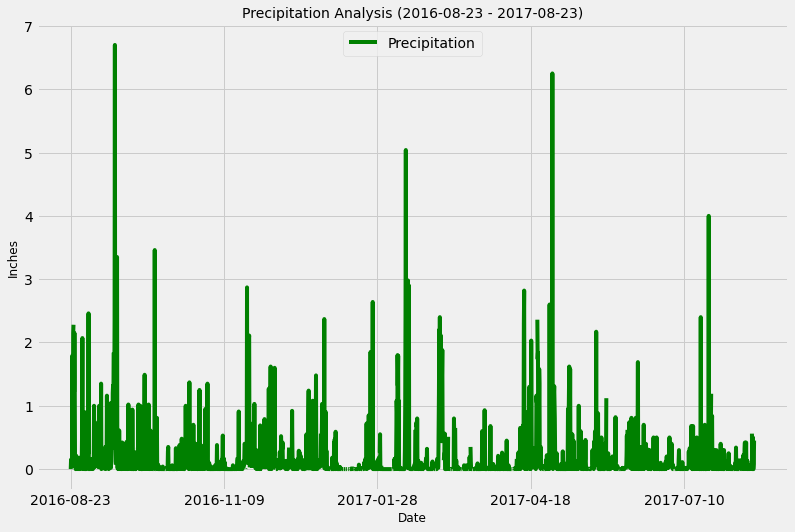

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(12,8), color='green')
plt.legend(loc="upper center")
plt.title("Precipitation Analysis (2016-08-23 - 2017-08-23)",fontsize =14)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Inches",fontsize=12)
plt.savefig("Images/precip_analysis.png")
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
##########################

# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(measurement.station).distinct().count()
station_count

9

In [23]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
total_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

total_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
top_station = total_stations[0][0]

stats = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station == top_station)
              
stats_list=list(stats)
print(stats_list)

[(54.0, 85.0, 71.66378066378067)]


In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(measurement.tobs).\
    filter(measurement.date >= year_ago).\
    filter(measurement.station == "USC00519281").\
    order_by(measurement.date).all()

# Save the Query Results as a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=["TOBS"])

tobs_df

,TOBS
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


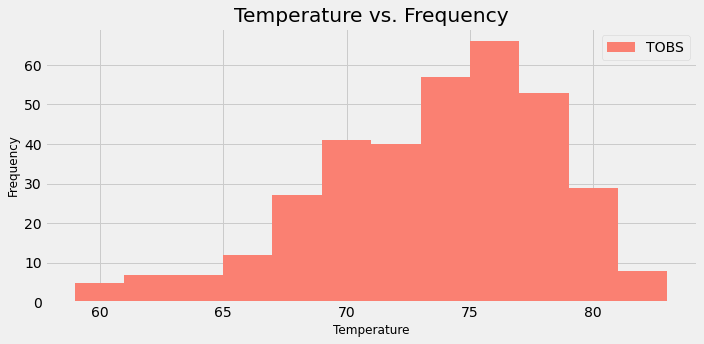

In [26]:
#plot the results as a histogram with 12 Bins
tobs_df.plot.hist(bins=12, title="Temperature vs. Frequency",fontsize=14, color="salmon", figsize=(10,5))
plt.xlabel("Temperature",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Images/temp_vs_freq_histogram.png")
plt.show()

# Close session

In [27]:
# Close Session
session.close()